In [3]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [4]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [5]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

In [6]:
sim0 = ('142', '116', '04')
sim1 = ('129', '116', '04')

In [7]:
def load_galaxy(sim, idx=320):
    Rs, Vv, ecc = sim
    key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc
    return galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              idx, orient=True)

In [8]:
gal0 = load_galaxy(sim0)
# gal1 = load_galaxy(sim1)
galiso = galaxy.Galaxy(basepath + 'runs/MW7iso/lvl4-Ngb64/output', 320, orient=True)

In [10]:
def extract_sim_data(gal):
    sn = gal.sn
    
    ### get logFeH and logMgFe ###
    FeH = sn.part4.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = sn.part4.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH

    ### get in_SN ###
    Lzsun = 8 * 220 * 0.2
    zmax = 3
    dLz = 0.3
    
    Lz = np.cross(sn.part4.rotpos, sn.part4.rotvel)[:,2]
    in_SN = np.logical_and(np.abs((Lz/Lzsun)-1) < dLz, np.abs(sn.part4.rotpos[:,2]) < zmax)
    
    ### get tform ###
    tform = sn.part4.GFM_StellarFormationTime
    keybool = np.logical_and(in_SN, tform > 0)
    
    out = {}
    out['logFeH'] = logFeH[in_SN]
    out['logMgFe'] = logMgFe[in_SN]
    out['tform'] = tform[in_SN]
    
    return out

simdata0 = extract_sim_data(gal0)
# simdata1 = extract_sim_data(gal1)
simdataiso = extract_sim_data(galiso)

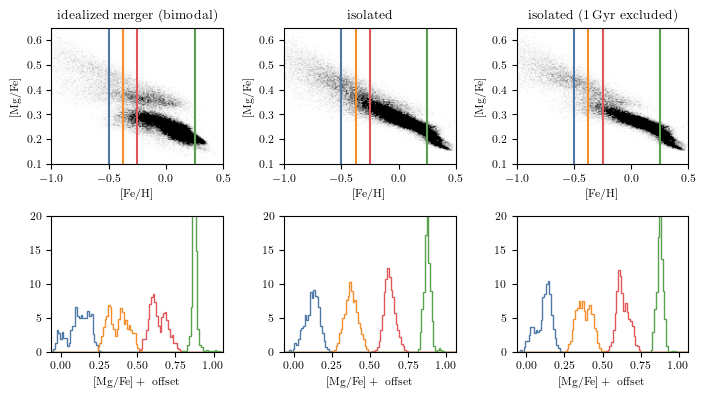

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(textwidth, 1.2*columnwidth))

N_FeH = 125
N_MgFe = 125

def plot_panel(data, fig, ax0, ax1, logFeH_lim, logMgFe_lim, logFeH0_list, 
               offset=-0.3, doffset = 0.4, poffset=0.4, vmax=1e5, exclude=None):
    logFeH = data['logFeH']
    logMgFe = data['logMgFe']
    tform = data['tform']
    
    if exclude is not None:
        key = np.logical_or(tform < exclude[0], tform > exclude[1])
        logFeH = logFeH[key]
        logMgFe = logMgFe[key]
        tform = tform[key]
    
    FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
    MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
    dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
    dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe
    H, _, _, _ = binned_statistic_2d(logFeH, logMgFe, 
                                     np.ones(len(logFeH))/dFeH/dMgFe,
                                     statistic='sum', bins=[FeH_bins, MgFe_bins])
    
    im = ax0.imshow(H.T, origin='lower', extent=[logFeH_lim[0],  logFeH_lim[1],
                                                    logMgFe_lim[0], logMgFe_lim[1]],
                       cmap='Greys', vmin=0, vmax=vmax)
    
    ax0.set(xlim=logFeH_lim, ylim=logMgFe_lim)
    ax0.set(xlabel=r'$[\textrm{Fe}/\textrm{H}]$', ylabel=r'$[\textrm{Mg}/\textrm{Fe}]$')
    ax0.set(aspect='auto')
    
    dlogFeH0 = 0.05
    d = 0.25/2
    offset_list = [d, 0.25+d, 0.5+d, 0.75+d]
    for i,(logFeH0, c) in enumerate(zip(logFeH0_list, [tb_c[0], tb_c[1], tb_c[2], tb_c[4]])):
        offset = offset_list[i]
        key = np.logical_and(logFeH > logFeH0 - dlogFeH0/2., logFeH < logFeH0 + dlogFeH0/2.)
    
        _, _, l = ax1.hist(logMgFe[key]-np.median(logMgFe[key])+offset, 
                              bins=np.linspace(-d/2, 1+d/2, 100+1),
                              density=True, histtype='step', color=c)

        # print(dir(l[0]))
        ax0.axvline(logFeH0, c=l[0].get_edgecolor())
        
        offset += doffset
    
    ax1.set(ylim=(0, 20), xlim=(-d/2, 1+d/2))
    
    # ax0.set(xticks=np.arange(-1, 0.5+0.25, 0.25))
    ax1.set(xlabel=r'$[\textrm{Mg}/\textrm{Fe}] + \textrm{ offset}$')
    
logFeH0_list=[-0.5, -0.375, -0.25, 0.25]
plot_panel(simdata0, fig, axs[0][0], axs[1][0], (-1, 0.5), (0.1, 0.65), logFeH0_list, 
           doffset=0.3, poffset=0.1, vmax=4e5)
plot_panel(simdataiso, fig, axs[0][1], axs[1][1], (-1, 0.5), (0.1, 0.65), logFeH0_list, 
           doffset=0.3, poffset=0.1, vmax=4e5)
plot_panel(simdataiso, fig, axs[0][2], axs[1][2], (-1, 0.5), (0.1, 0.65), logFeH0_list, 
           doffset=0.3, poffset=0.1, vmax=4e5, exclude=(2, 3))
# plot_panel(simdata1, fig, axs[0][2], (-1, 0.5), (0., 0.8))

axs[0][0].set_title(r'$\textrm{idealized merger (bimodal)}$')
axs[0][1].set_title(r'$\textrm{isolated}$')
axs[0][2].set_title(r'$\textrm{isolated ($1\,\textrm{Gyr}$ excluded)}$')
# axs[0][2].text(-0.3, 0.65, r'$\textrm{slightly different}$', fontsize='x-small')
# axs[0][2].text(-0.3, 0.6, r'$\textrm{orbital parameters}$', fontsize='x-small')

fig.tight_layout()
fig.savefig('exclude_plot.pdf')